# Import Library

In [ ]:
import pandas as pd
import datarobot as dr
import numpy as np
import requests
import io
import PIL.Image

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib import pyplot as plt
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox
import seaborn as sns

from IPython.core.display import display, HTML

from datarobot import AUTOPILOT_MODE
from datarobot.models import Project, Dataset
from datarobot.models.visualai import SampleImage, ImageActivationMap, ImageEmbedding
from graphviz import Source

# Define Credentials & Project Settings

To make sure only authorized users access the DataRobot API, you need an API token. To get a token, log in to the DataRobot web UI, click your profile icon, and select Developer Tools. API tokens are shown under API Keys, and you can create a new one if needed.

In [ ]:
ENDPOINT = "YOUR_DATAROBOT_ENDPOINT"
DATAROBOT_URL = "YOUR_DATAROBOT_URL"
API_TOKEN = "YOUR_API_TOKEN"

dr.Client(token=API_TOKEN, endpoint=ENDPOINT)

S3_DATA_PATH = "https://s3.amazonaws.com/datarobot_public_datasets/Images/oxford_pets_dataset.zip"

PROJECT_NAME = "oxford_pets_dataset_demo_notebook" # name of the project
IMAGE_COLUMN = "image" # image column
TARGET_CLASS = "class" # target class
PROJECT_METRIC = "Accuracy" # project metric
SAMPLE_SIZE = 5 # number of sample size for image sampling and activation maps
EMBEDDINGS_SAMPLE = 50 # number of image samples for Image Embeddings

In [ ]:
project = dr.Project.start(S3_DATA_PATH, #Pandas Dataframe with data. Could also pass the folder link itself
                           project_name = PROJECT_NAME,#Name of the project
                           target = TARGET_CLASS,        #Target of the project
                           worker_count = -1,            #Number of workers to use. -1 means use all available workers
                           autopilot_on = True)          #Run on Autopilot (Default value)

project.wait_for_autopilot(check_interval=300) #Wait for Autopilot to complete; check every 5 minutes
project_id = project.id

In progress: 5, queued: 0 (waited: 0s)
In progress: 5, queued: 0 (waited: 1s)
In progress: 5, queued: 0 (waited: 2s)
In progress: 5, queued: 0 (waited: 3s)
In progress: 5, queued: 0 (waited: 5s)
In progress: 5, queued: 0 (waited: 7s)
In progress: 5, queued: 0 (waited: 11s)
In progress: 5, queued: 0 (waited: 18s)
In progress: 5, queued: 0 (waited: 32s)
In progress: 4, queued: 0 (waited: 58s)
In progress: 3, queued: 0 (waited: 110s)
In progress: 1, queued: 0 (waited: 214s)
In progress: 1, queued: 0 (waited: 420s)
In progress: 3, queued: 0 (waited: 721s)
In progress: 3, queued: 0 (waited: 1022s)
In progress: 20, queued: 0 (waited: 1323s)
In progress: 6, queued: 0 (waited: 1625s)
In progress: 5, queued: 0 (waited: 1927s)
In progress: 1, queued: 0 (waited: 2228s)
In progress: 1, queued: 0 (waited: 2530s)
In progress: 0, queued: 0 (waited: 2831s)
In progress: 0, queued: 0 (waited: 3132s)


# Helper functions for Leaderboard interpretation

In [ ]:
def get_model_score(mod, metric):
    res = {}
    res['model_number'] = mod.model_number
    res['model_type'] = mod.model_type
    res['sample_pct'] = mod.sample_pct
    
    res['metric_v'] = mod.metrics.get(metric, {}).get('validation')
    res['metric_cv'] = mod.metrics.get(metric, {}).get('crossValidation')
    
    return res

def get_model_scores(proj, metric=None, ascending=True):
    """
    iterate through the project models and get their performance metrics
    """
    if metric is None:
        metric = proj.metric        
    df = pd.DataFrame([get_model_score(m, metric) for m in proj.get_models(with_metric=metric)])
    return df.sort_values(['metric_cv', 'metric_v'], ascending=ascending, na_position='last')

def get_model_number_to_network_mapping(models_endpoint, api_token):
    # retrieve the pretrained Neural Network model for each model_number on the Leaderboard
    response = requests.get(models_endpoint, headers={'Authorization': 'Token {}'.format(api_token)})
    if response.status_code != 200:
        msg = 'API returned a non-200 status code (is your API token valid for this project?)'
        raise RuntimeError(msg)
    
    df = pd.DataFrame(columns=['model_number','pretrained_network'])
    
    network_name_in_bp = "No pretrained model"
    
    result = response.json()
    
    for idx in range(len(result)):
        model_number = result[idx]["modelNumber"]
        model_graph = result[idx]["processes"]
        
        network_name_in_bp_graph = network_name_in_bp
        
        for graph_node in model_graph:
            if "Pretrained" in graph_node:
                network_name_in_bp_graph = graph_node
        
        df = df.append({'model_number' : np.int64(model_number), 'pretrained_network' : network_name_in_bp_graph}, ignore_index=True)
    
    df["model_number"] = df["model_number"].astype(np.int64)
    
    return df

In [ ]:
# get model_id -> neural network name mapping
models_leaderboard_endpoint = "{}/projects/{}/models".format(ENDPOINT,project_id)
blueprint_to_pretrained_network = get_model_number_to_network_mapping(models_leaderboard_endpoint, API_TOKEN)
model_scores = get_model_scores(project, metric=PROJECT_METRIC, ascending=False)
model_scores = model_scores.merge(blueprint_to_pretrained_network, on=['model_number'])

# Best Model on the Leaderboard (including pretrained Neural Network )

In [ ]:
model_scores.head(1)

,metric_cv,metric_v,model_number,model_type,sample_pct,pretrained_network
0,0.930818,0.93153,47,Keras Slim Residual Neural Network Classifier ...,63.9919,Pretrained EfficientNet-b0-Pruned Multi-Level ...


# Total Number of models on the Leaderboard

In [ ]:
len(model_scores)

17

# DAG visualization of best model

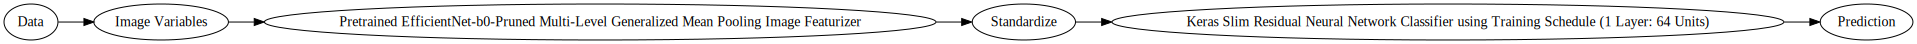

In [ ]:
best_model_on_lb = project.get_models()[0] # top model from the LB
filtered_chart = best_model_on_lb.get_model_blueprint_chart()
Source(filtered_chart.to_graphviz())

# Detailed Confusion Chart

In [ ]:
best_validation_model = project.get_models(order_by = '-metric')[1]

confusion_chart = best_validation_model.get_confusion_chart(source='validation')
pd.DataFrame(confusion_chart.class_metrics)

,actual_count,class_name,confusion_matrix_one_vs_all,f1,precision,predicted_count,recall,was_actual_percentages,was_predicted_percentages
0,32,Abyssinian,"[[1151, 0], [1, 31]]",0.984127,1.000000,31,0.968750,"[{u'percentage': 0.96875, u'other_class_name':...","[{u'percentage': 1.0, u'other_class_name': u'A..."
1,28,Bengal,"[[1151, 4], [7, 21]]",0.792453,0.840000,25,0.750000,"[{u'percentage': 0.0, u'other_class_name': u'A...","[{u'percentage': 0.0, u'other_class_name': u'A..."
2,33,Birman,"[[1143, 7], [5, 28]]",0.823529,0.800000,35,0.848485,"[{u'percentage': 0.0, u'other_class_name': u'A...","[{u'percentage': 0.0, u'other_class_name': u'A..."
3,36,Bombay,"[[1145, 2], [1, 35]]",0.958904,0.945946,37,0.972222,"[{u'percentage': 0.0, u'other_class_name': u'A...","[{u'percentage': 0.0, u'other_class_name': u'A..."
4,29,British_Shorthair,"[[1148, 6], [3, 26]]",0.852459,0.812500,32,0.896552,"[{u'percentage': 0.0, u'other_class_name': u'A...","[{u'percentage': 0.03125, u'other_class_name':..."
5,35,Egyptian_Mau,"[[1141, 7], [3, 32]]",0.864865,0.820513,39,0.914286,"[{u'percentage': 0.0, u'other_class_name': u'A...","[{u'percentage': 0.0, u'other_class_name': u'A..."
6,36,Maine_Coon,"[[1144, 3], [5, 31]]",0.885714,0.911765,34,0.861111,"[{u'percentage': 0.0, u'other_class_name': u'A...","[{u'percentage': 0.0, u'other_class_name': u'A..."
7,28,Persian,"[[1154, 1], [0, 28]]",0.982456,0.965517,29,1.000000,"[{u'percentage': 0.0, u'other_class_name': u'A...","[{u'percentage': 0.0, u'other_class_name': u'A..."
8,34,Ragdoll,"[[1142, 7], [3, 31]]",0.861111,0.815789,38,0.911765,"[{u'percentage': 0.0, u'other_class_name': u'A...","[{u'percentage': 0.0, u'other_class_name': u'A..."
9,37,Russian_Blue,"[[1143, 3], [6, 31]]",0.873239,0.911765,34,0.837838,"[{u'percentage': 0.0, u'other_class_name': u'A...","[{u'percentage': 0.0, u'other_class_name': u'A..."


# Visual Confusion Matrix

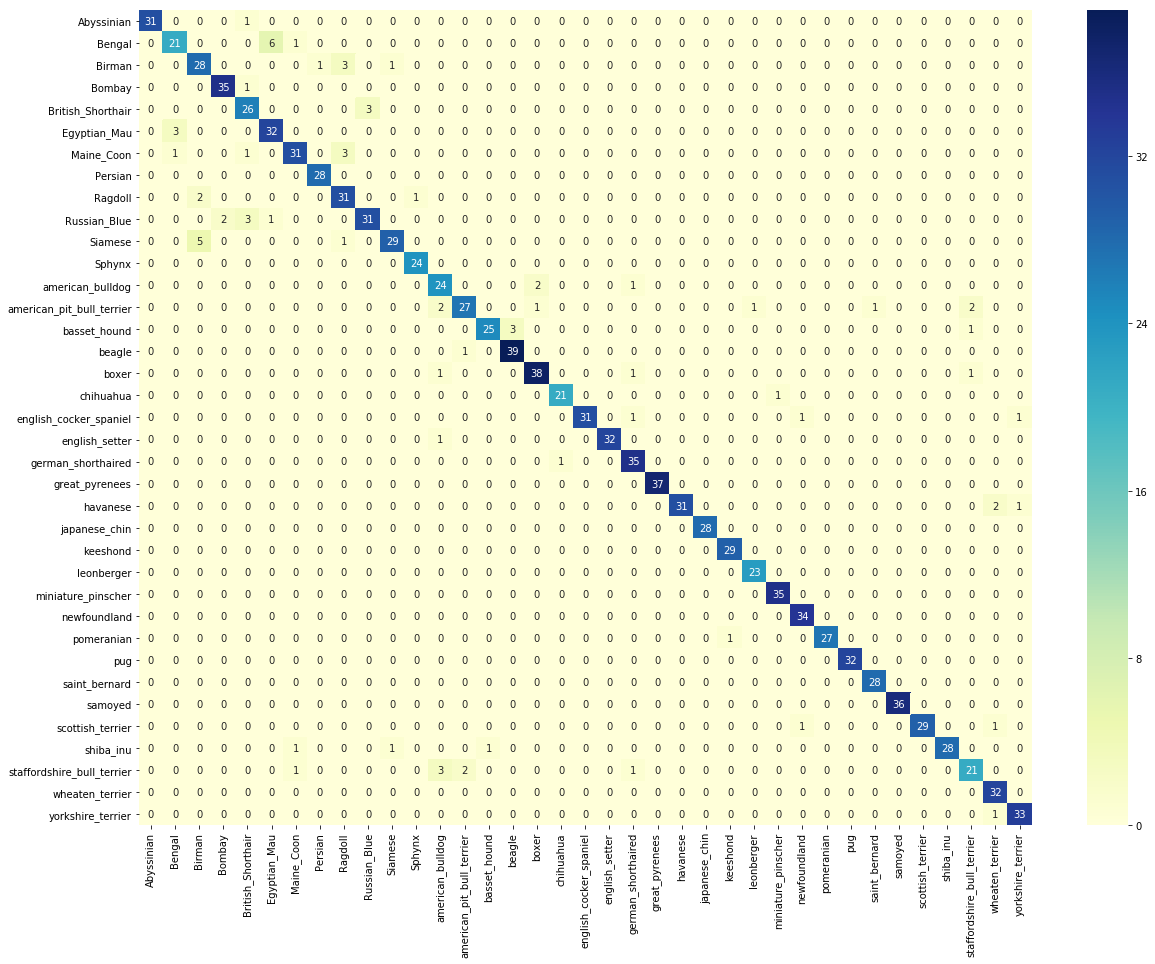

In [ ]:
chart = best_validation_model.get_confusion_chart(dr.enums.CHART_DATA_SOURCE.VALIDATION)

plt.subplots(figsize=(20,15))
sns.heatmap(chart.confusion_matrix, 
           annot=True, 
           xticklabels=chart.classes, 
           yticklabels=chart.classes,
           cmap='YlGnBu')

# Additional Project Insights

To view and use model insights in the DataRobot web UI, select Models in the top menu and then click Insights. Select the insights you want to examine such as Activation Maps, Model Embeddings, etc.

# Generate Image Samples ( Quick Data Lookup )

target value = english_setter


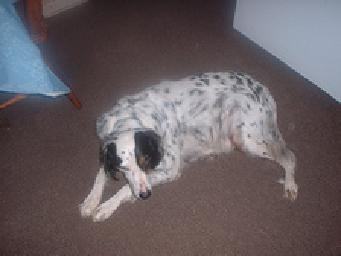

target value = havanese


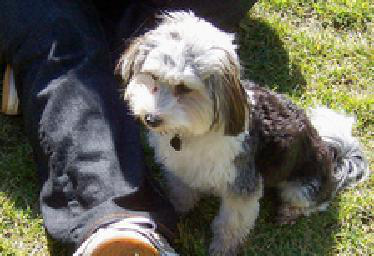

target value = basset_hound


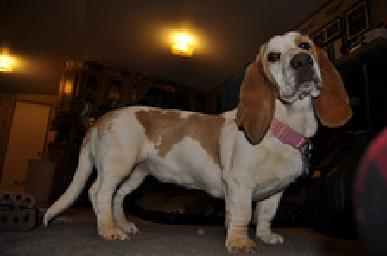

target value = basset_hound


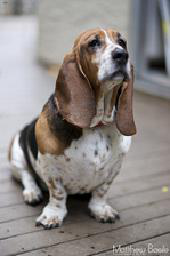

target value = havanese


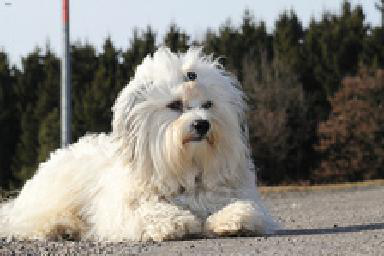

In [ ]:
for sample in SampleImage.list(project.id, IMAGE_COLUMN)[:SAMPLE_SIZE]:
    print("target value = {}".format(sample.target_value))
    bio = io.BytesIO(sample.image.image_bytes)
    img = PIL.Image.open(bio)
    display(img)

# Activation Maps

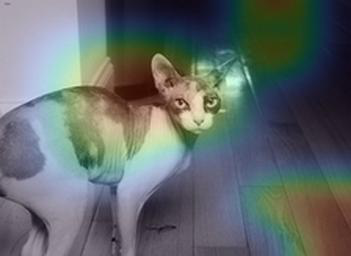

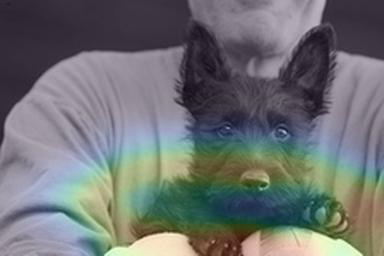

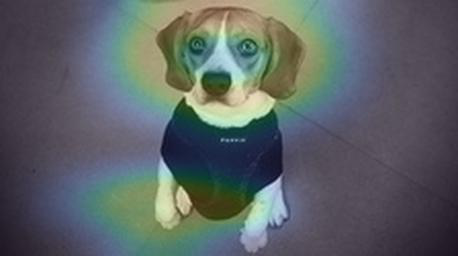

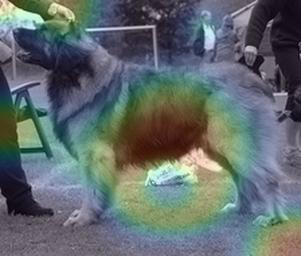

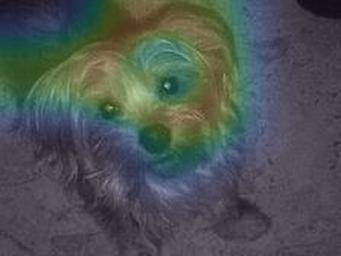

In [ ]:
for model_id, feature_name in ImageActivationMap.models(project.id):
    for amap in ImageActivationMap.list(project.id, model_id, IMAGE_COLUMN)[:SAMPLE_SIZE]:
   
        bio = io.BytesIO(amap.overlay_image.image_bytes)
        img = PIL.Image.open(bio)
        display(img)

# Unsupervised Image Embeddings

In [ ]:
# helper function for visualizing image embeddings, by mapping coordinates to a point on the image
def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        bio = io.BytesIO(image.image.image_bytes)
        image = plt.imread(bio, format='JPG')
    except TypeError:
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

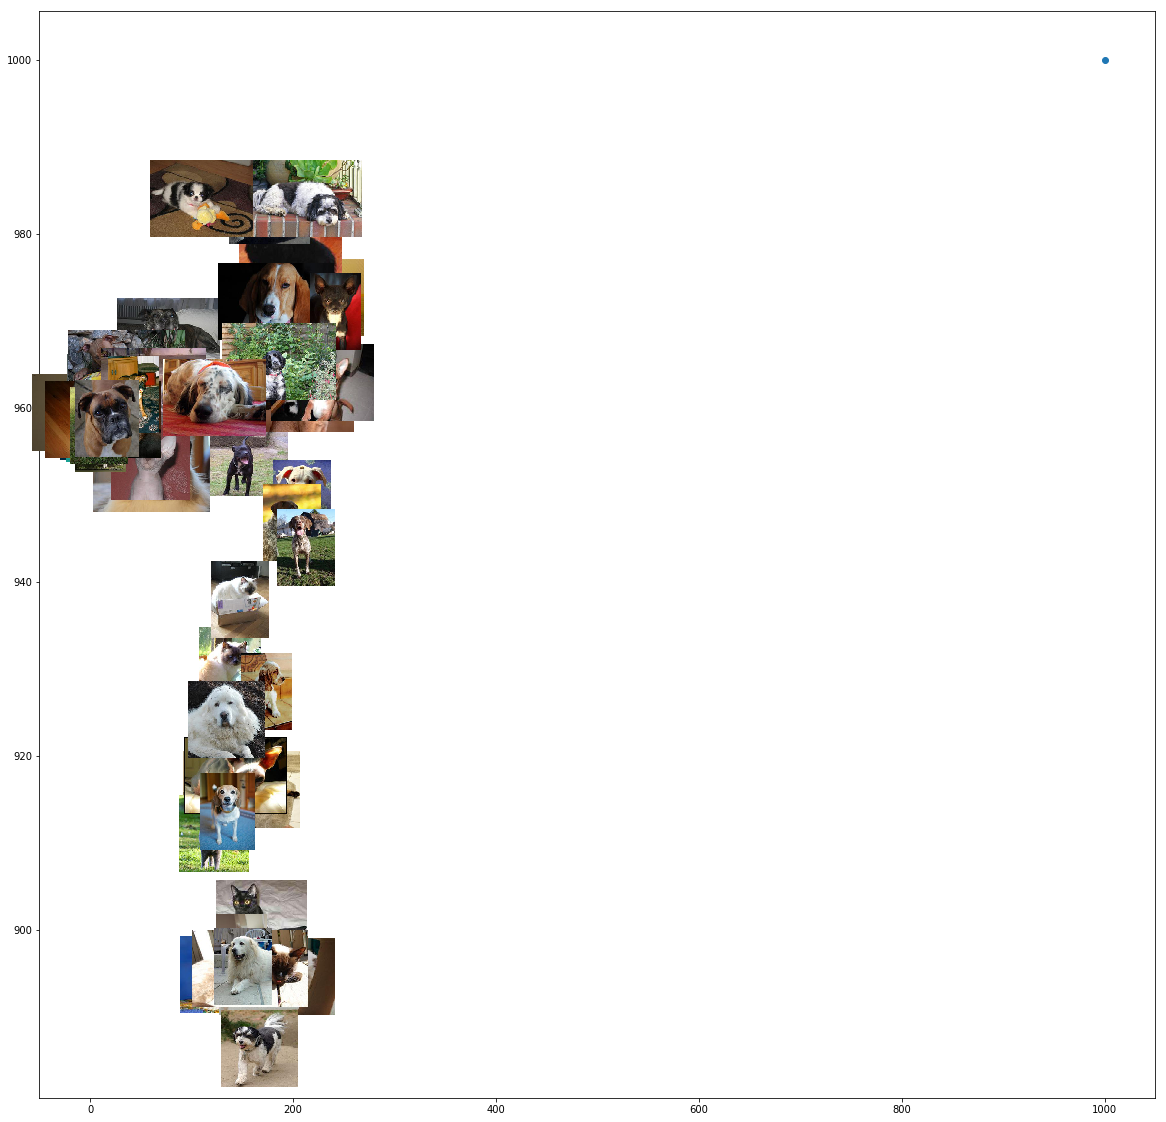

In [ ]:
# style/visualization settings
fig, ax = plt.subplots()
fig.set_figheight(20)
fig.set_figwidth(20)
ax.scatter(1000, 1000)
scaling_factor = 1000.0


project = Project.list(search_params={"project_name": PROJECT_NAME})[0]

for model_id, feature_name in ImageEmbedding.models(project.id):
    
    
    for embedding in ImageEmbedding.list(project.id, model_id, IMAGE_COLUMN)[:EMBEDDINGS_SAMPLE]:
        imscatter(embedding.position_x*scaling_factor, 
                  embedding.position_y*scaling_factor, 
                  embedding, 
                  zoom=0.3, # control image size on the grid
                  ax=ax)
plt.show()

# Predictions
## Model API
You can use the Model API if you use Python or R and there are multiple ways you can interact with it.


## Using the Model API

In [ ]:
TEST_DATA_S3_PATH = "https://s3.amazonaws.com/datarobot_public_datasets/Images/oxford_pets_sample_test_data.zip"

# making predictions with the best model on the Leaderboard
prediction_data = project.upload_dataset(TEST_DATA_S3_PATH)
predict_job = best_model_on_lb.request_predictions(prediction_data.id)
result = predict_job.get_result_when_complete()

In [ ]:
result.head()

,prediction,row_id,class_Abyssinian,class_Bengal,class_Birman,class_Bombay,class_British_Shorthair,class_Egyptian_Mau,class_Maine_Coon,class_Persian,...,class_newfoundland,class_pomeranian,class_pug,class_saint_bernard,class_samoyed,class_scottish_terrier,class_shiba_inu,class_staffordshire_bull_terrier,class_wheaten_terrier,class_yorkshire_terrier
0,yorkshire_terrier,0,4.726769e-04,2.538795e-04,9.452998e-05,2.046641e-04,2.316154e-05,5.420223e-06,3.382546e-04,3.427301e-05,...,4.919421e-05,0.000289,2.183647e-04,0.000050,1.664166e-04,1.004383e-04,0.000009,1.506541e-03,2.226572e-04,0.977258
1,chihuahua,1,4.660016e-05,3.780265e-07,1.877734e-06,2.020987e-06,2.609716e-06,2.117352e-05,5.783692e-07,2.339096e-06,...,4.518940e-06,0.000018,1.335282e-06,0.000047,6.695904e-07,1.217344e-05,0.000129,1.025800e-05,1.585628e-05,0.000003
2,yorkshire_terrier,2,6.718448e-06,5.970629e-06,3.947175e-07,9.380416e-06,1.070332e-06,2.247205e-06,2.448789e-05,6.045263e-06,...,2.737145e-06,0.000089,1.936295e-06,0.000006,5.477920e-07,4.773179e-06,0.000020,7.301498e-06,3.728945e-06,0.999688
3,yorkshire_terrier,3,4.553043e-07,1.153547e-06,1.032064e-06,4.400508e-07,2.421089e-07,1.679840e-07,2.885086e-06,1.230804e-07,...,2.324064e-07,0.000013,5.942930e-08,0.000004,8.607338e-08,3.396210e-05,0.000012,3.399845e-06,5.081894e-07,0.999839
4,Abyssinian,4,9.993568e-01,1.297096e-05,4.745283e-06,1.758190e-05,6.153412e-05,2.744098e-05,4.656963e-06,4.788974e-07,...,2.020641e-06,0.000008,1.456358e-06,0.000056,8.890467e-06,9.796890e-07,0.000021,3.579473e-07,7.505644e-05,0.000011
